## Loading

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import helper 
from collections import defaultdict
import warnings
import mplfinance as mpf
from sklearn.metrics import mean_squared_error, r2_score

current_path = os.getcwd()

SEED = 2023

# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

In [7]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MA_Volume,Relative_Difference,volume_dip,minor_dip,minor_spike,volume_spike,volume_class
0,2010-01-04,3.859,3.859,3.808,3.841,3.841,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neutral
1,2010-01-05,3.790,3.800,3.749,3.755,3.755,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,Neutral
2,2010-01-06,3.771,3.837,3.761,3.808,3.808,0,38.129494,NaN,NaN,NaN,NaN,NaN,NaN,Neutral
3,2010-01-07,3.845,3.859,3.800,3.822,3.822,0,43.790827,NaN,NaN,NaN,NaN,NaN,NaN,Neutral
4,2010-01-08,3.843,3.851,3.775,3.808,3.808,0,40.119752,NaN,NaN,NaN,NaN,NaN,NaN,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,2022-12-23,3.701,3.753,3.695,3.751,3.751,0,58.539320,0.0,NaN,NaN,NaN,NaN,NaN,Neutral
3265,2022-12-27,3.787,3.862,3.787,3.860,3.860,0,69.003272,0.0,NaN,NaN,NaN,NaN,NaN,Neutral
3266,2022-12-28,3.818,3.890,3.815,3.887,3.887,0,78.682623,0.0,NaN,NaN,NaN,NaN,NaN,Neutral
3267,2022-12-29,3.868,3.886,3.818,3.835,3.835,0,71.393025,0.0,NaN,NaN,NaN,NaN,NaN,Neutral


In [12]:
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", '^TNX']
start_date = "2010-01-01"
end_date = "2023-01-01"
stock_data = {}
MAs = [5, 10, 20, 50, 100, 200]

for stock in STOCKS: 
    try:
        data_path = current_path + "\data" f"\{stock}_{start_date}_{end_date}.csv"
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        if stock != "^TNX":
            data['rsi_class'] = helper.compute_rsi_class(data)  # Assuming you have this function in helper
            data['volume_class'] = helper.compute_volume_class(data)  # Add volume analysis
            data = helper.calculate_mas(data, MAs, column_name="Close")
            data['WVAD'] = helper.calculate_wvad(data, period=14)
            data['ROC'] = helper.calculate_roc(data, period=14)
            data['MACD'], data['macd_line'], data['signal_line'] = helper.calculate_macd(data, short_window=12, long_window=26, signal_window=9)
            data['CCI'] =  helper.calculate_cci(data, period=20)
            data['Upper Band'], data['Lower Band'], data['SMA'] = helper.calculate_bollinger_bands(data, window=20, num_std_dev=2)
            data['SMI'] = helper.calculate_smi(data, period=14, signal_period=3)
            data['ATR'] = helper.calculate_atr(data, period=14)
        stock_data[stock] = data
        print(f"Data fetched for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {str(e)}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for ^TNX


In [13]:
stock_data['AAPL'].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
       'rsi_class', 'MA_Volume', 'Relative_Difference', 'volume_dip',
       'minor_dip', 'minor_spike', 'volume_spike', 'volume_class', 'MA5',
       'MA10', 'MA20', 'MA50', 'MA100', 'MA200', 'WVAD', 'ROC', 'MACD',
       'macd_line', 'signal_line', 'CCI', 'Upper Band', 'Lower Band', 'SMA',
       'SMI', 'ATR'],
      dtype='object')

## Model

### XGBoost

In [16]:
stock_data[stock].columns, max(stock_data[stock]['Date']), min(stock_data[stock]['Date'])

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
        'rsi_class', 'MA_Volume', 'Relative_Difference', 'volume_dip',
        'minor_dip', 'minor_spike', 'volume_spike', 'volume_class', 'MA5',
        'MA10', 'MA20', 'MA50', 'MA100', 'MA200', 'WVAD', 'ROC', 'MACD',
        'macd_line', 'signal_line', 'CCI', 'Upper Band', 'Lower Band', 'SMA',
        'SMI', 'ATR'],
       dtype='object'),
 Timestamp('2022-12-30 00:00:00'),
 Timestamp('2010-01-04 00:00:00'))

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing: 100%|██████████| 2866/2866 [02:11<00:00, 21.72it/s]


Mean Squared Error (MSE): 4.8594886373102595
Mean Absolute Percentage Error (MAPE): 1.95%


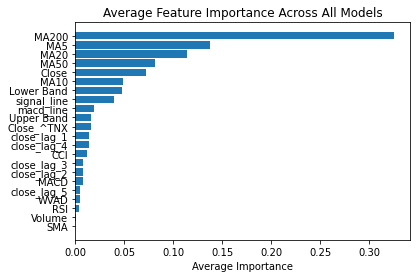

Wall time: 2min 12s


In [20]:
%%time
fromDate = "2010-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
stock = 'AAPL'
late = 5
window_size = 200 

apple_df = stock_data[stock][:].copy()
apple_df = apple_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'WVAD', 'MACD','macd_line', 'signal_line', 'CCI', 'Upper Band', 'SMA', 'Lower Band']] 

# adding other stocks, economic indicator
dataToAdd = ['^TNX']
for item in dataToAdd:
    apple_df = apple_df.merge(stock_data[item][['Date', 'Close']], left_on="Date", right_on="Date", how='inner', suffixes=("", f'_{item}'))


apple_df['Date'] = pd.to_datetime(apple_df['Date'])
apple_df.set_index('Date', inplace=True)
apple_df =  apple_df[(apple_df.index <= toDate) & (apple_df.index >= fromDate)]


# apple_df['relative_volume'] = apple_df['Volume'] / apple_df['MA_Volume'] 
# apple_df['rsi_class'] = apple_df['rsi_class'].astype('category')
# apple_df['rsi_class'] = apple_df['rsi_class'].cat.codes
cumulative_importances = defaultdict(float)
apple_df[f'Close_{late}_days_later'] = apple_df['Close'].shift(-5)
apple_df = apple_df[~apple_df['Close_5_days_later'].isna()]

# apple_df['greenDay'] = apple_df['Open'] > apple_df['Close']
# apple_df['open_close_diff'] = apple_df['Close'] - apple_df['Open']/ apple_df['Open']
# apple_df['high_close_diff'] = apple_df.apply(lambda row: (row['High'] - row['Low'])/row['Low'] * (1 if row['greenDay'] else -1), axis=1)
apple_df['MACD'] = apple_df['macd_line'] - apple_df['signal_line']

for i in range(1, 6):  # for lag days 
    apple_df[f'close_lag_{i}'] = apple_df['Close'].shift(i)
    # apple_df[f'Open_lag_{i}'] = apple_df['Open'].shift(i)
    # apple_df[f'High_lag_{i}'] = apple_df['High'].shift(i)
    # apple_df[f'Low_lag_{i}'] = apple_df['Low'].shift(i)
    #apple_df[f'volume_lag_{i}'] = apple_df['Volume'].shift(i)
    # If RSI exists, uncomment the following:
    #apple_df[f'RSI_lag_{i}'] = apple_df['RSI'].shift(i)

    
with SuppressFutureWarnings():
    apple_df = apple_df.dropna()
    toDrop = ['Open', 'High', 'Low', 'Close_5_days_later']
    columns_to_drop = []  
    for item in apple_df.columns:
        if item in toDrop:
            columns_to_drop.append(item)
    X = apple_df.drop(columns_to_drop, axis=1)
    y = apple_df['Close_5_days_later']


    predictions = []
    true_values = []
    current_price = []
    cumulative_importances = defaultdict(float)

    with SuppressFutureWarnings():
        for start in tqdm(range(0, X.shape[0] - window_size), desc="Processing"):
            end = start + window_size
            
            X_train, X_test = X.iloc[start:end], X.iloc[end:end+1]
            y_train, y_test = y.iloc[start:end], y.iloc[end:end+1]

            model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=SEED)
            model.fit(X_train, y_train)

            importances = model.feature_importances_
            for i, col in enumerate(X.columns):
                cumulative_importances[col] += importances[i]

            y_pred = model.predict(X_test)
            current_price.append(X_test['Close'])
            predictions.append(y_pred[0])
            true_values.append(y_test.iloc[0])

num_models = len(apple_df) - window_size
for key in cumulative_importances:
    cumulative_importances[key] /= num_models


MSE = mean_squared_error(true_values, predictions)
print(f'Mean Squared Error (MSE): {MSE}')

MAPE = helper.mean_absolute_percentage_error(true_values, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%')

# Plotting the average feature importance
sorted_features = sorted(cumulative_importances.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_features)

plt.barh(features, importance_values)
plt.xlabel('Average Importance')
plt.title('Average Feature Importance Across All Models')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()



c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


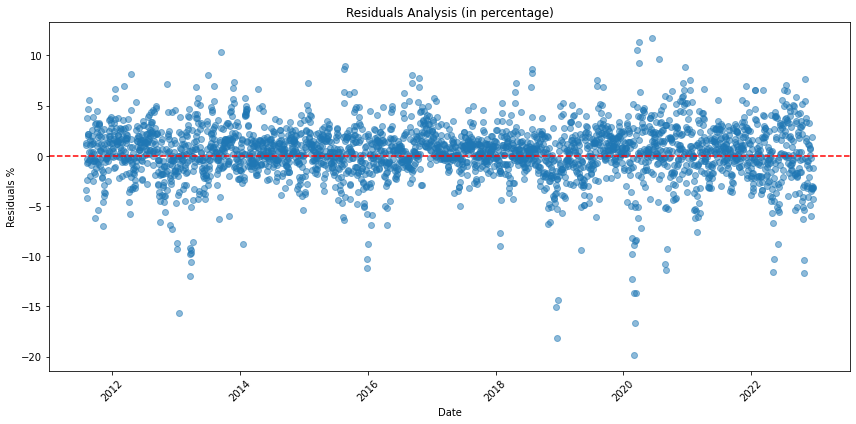

In [21]:
residuals_percentage = [(true - pred)/true * 100 for true, pred in zip(true_values, predictions)]

plt.figure(figsize=(12, 6))
plt.scatter(apple_df.index.values[window_size:], residuals_percentage, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Analysis (in percentage)')
plt.ylabel('Residuals %')
plt.xlabel('Date')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

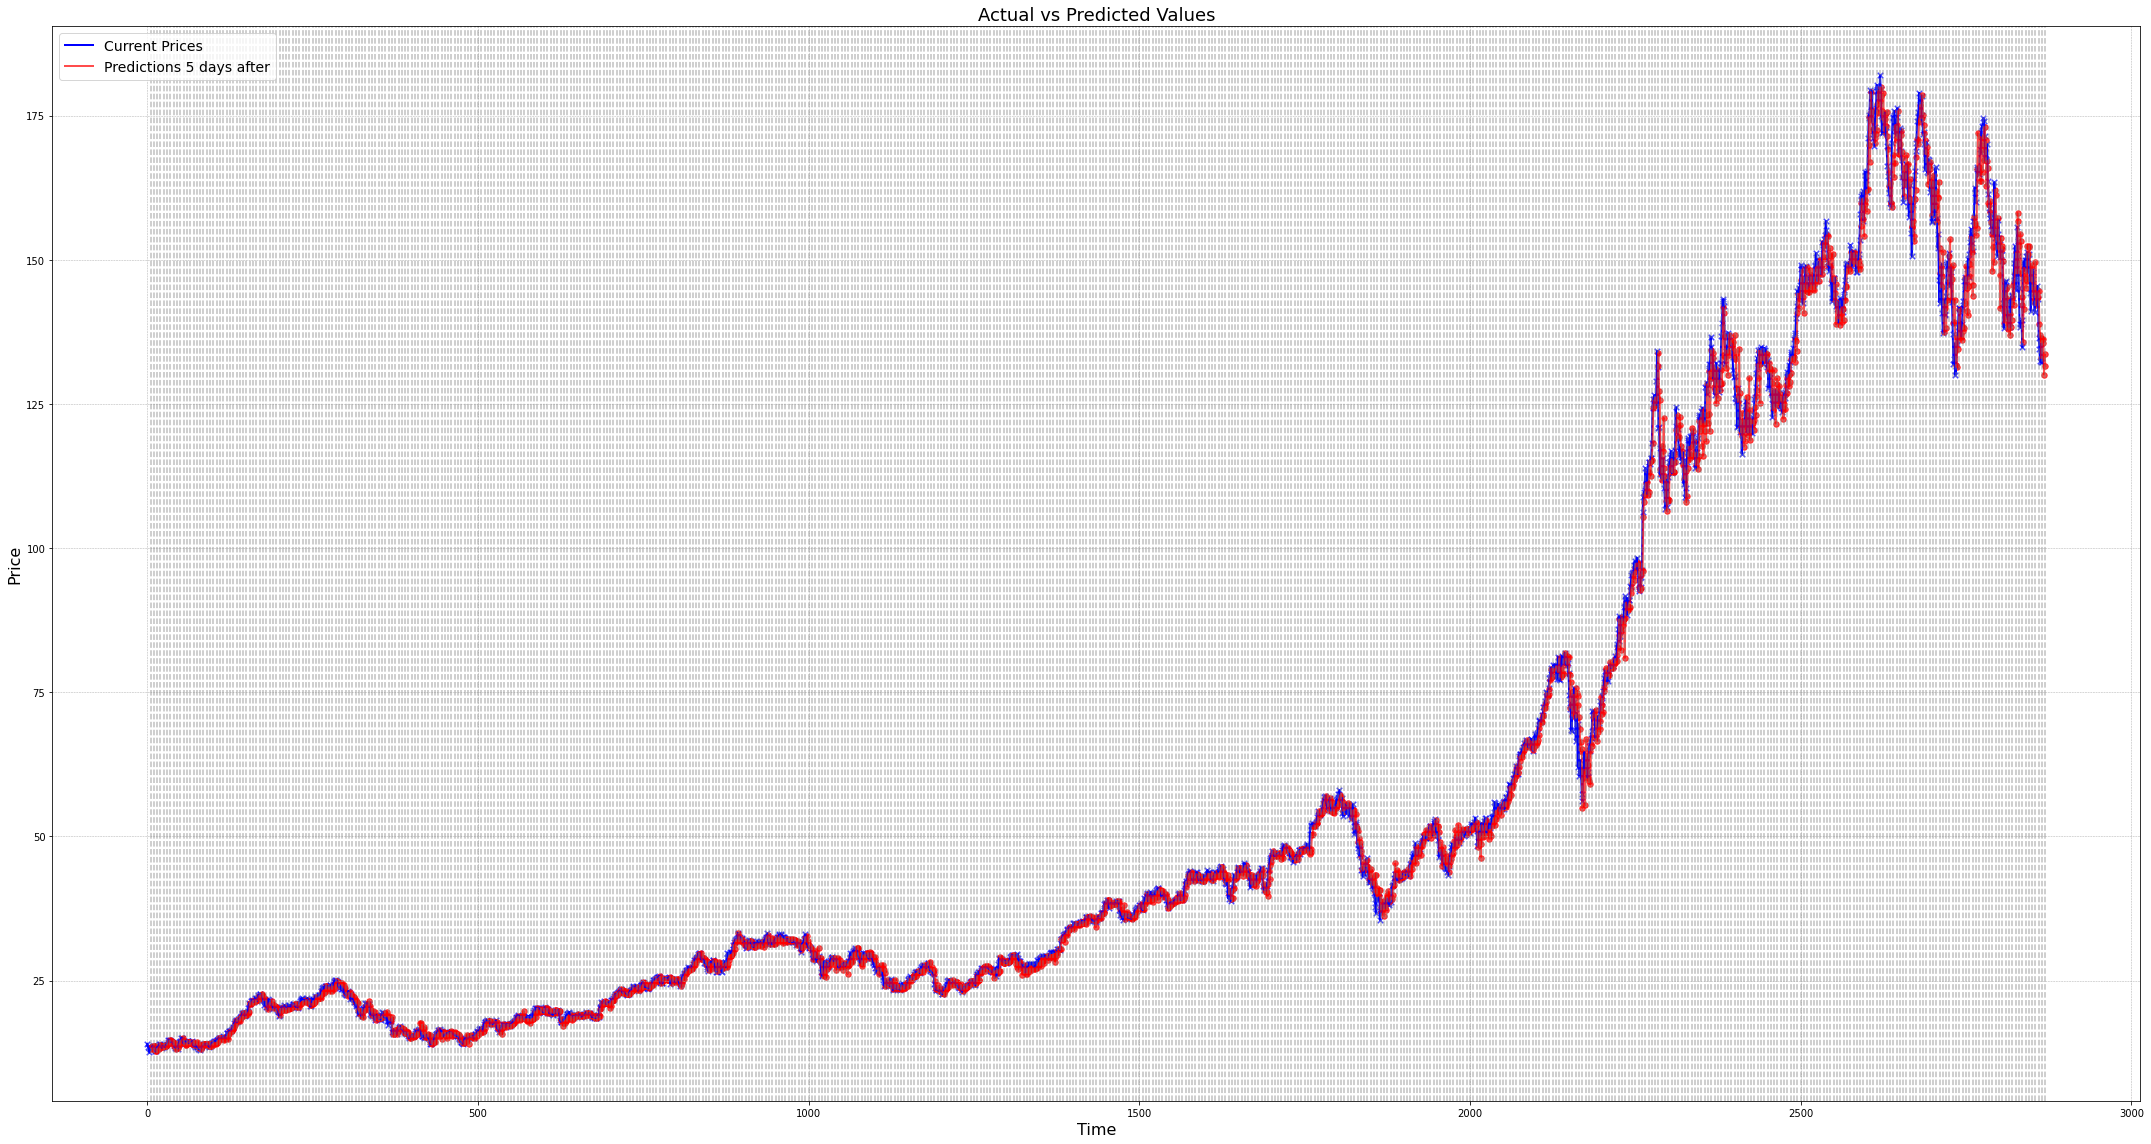

In [22]:
plt.figure(figsize=(30, 16))  # Keep the figure size large for clarity

# Plot the lines
plt.plot(current_price, label='Current Prices', linewidth=2, color='blue')
plt.plot(range(late, len(predictions)+late), predictions, label=f'Predictions {late} days after', color='red', alpha=0.7, linewidth=2)

# Scatter plot the data points 
plt.scatter(range(len(current_price)), current_price, s=30, marker='x', alpha=0.7, color='blue')  # Changed marker to 'x'
plt.scatter(range(late, len(predictions)+late), predictions, s=30, marker='o', alpha=0.7, color='red')  # Shifted predictions by 'late' days

# Labels, title, and legend
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Actual vs Predicted Values', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Highlighting the prediction horizon
for i in range(late, len(predictions)+late, late):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)  # Vertical lines to highlight the start of prediction periods

plt.tight_layout()
plt.show()


In [23]:
apple_df.loc[apple_df.index[window_size:], 'predictions'] = predictions
apple_df.loc[apple_df.index[window_size:], 'prediction_return'] = (apple_df['predictions'] - apple_df['Close']) / apple_df['Close']
apple_df['return_5_days'] = (apple_df['Close_5_days_later'] - apple_df['Close']) / apple_df['Close']

In [24]:
# Display statistics
stats = apple_df['Close'].resample('W').ffill().pct_change().describe()
stats

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    635.000000
mean       0.004682
std        0.038902
min       -0.175307
25%       -0.018332
50%        0.005994
75%        0.027215
max        0.147330
Name: Close, dtype: float64

In [28]:
# Initialize variables
weekly_returns = apple_df['Close'].resample('W').ffill().pct_change()
funds = 50000
stock_position = 0
date = apple_df.index[window_size:]
stock_price = apple_df['Close'].values[window_size:]
actual_return = apple_df['return_5_days'].values[window_size:]
actual_return_series = pd.Series(actual_return)
prediction_return = apple_df['prediction_return'].values[window_size:]
portfolio_value = []
buys, sells = [None] * len(prediction_return), [None] * len(prediction_return)

# Trading logic
for i in range(0, len(prediction_return)):
    # Adjust the current day to weekly index
    current_return_window = actual_return_series[max(0, i-window_size):i]
    stats = current_return_window.describe()
    buy_threshold = stats["75%"]
    sell_threshold = stats["25%"]
    
    past_predictions = prediction_return[i-4:i+1]

    # Accumulate buy and sell signals for the past 5 days
    buy_signals_count = sum(1 for p in past_predictions if p > buy_threshold)
    sell_signals_count = sum(1 for p in past_predictions if p < sell_threshold)

    # Execute Buy/Sell based on signals
    if buy_signals_count >= 2 and funds > 0:
        stocks_bought = funds // stock_price[i]
        funds -= stocks_bought * stock_price[i]
        stock_position += stocks_bought
        buys[i] = stock_price[i]
    elif sell_signals_count >= 2 and stock_position > 0:
        funds += stock_position * stock_price[i]
        stock_position = 0
        sells[i] = stock_price[i]

    # Update portfolio value
    portfolio_value.append(funds + stock_position * stock_price[i])

# Calculate portfolio percentage growth
starting_funds = 50000
portfolio_growth_percentage = [(value - starting_funds) / starting_funds * 100 for value in portfolio_value]

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


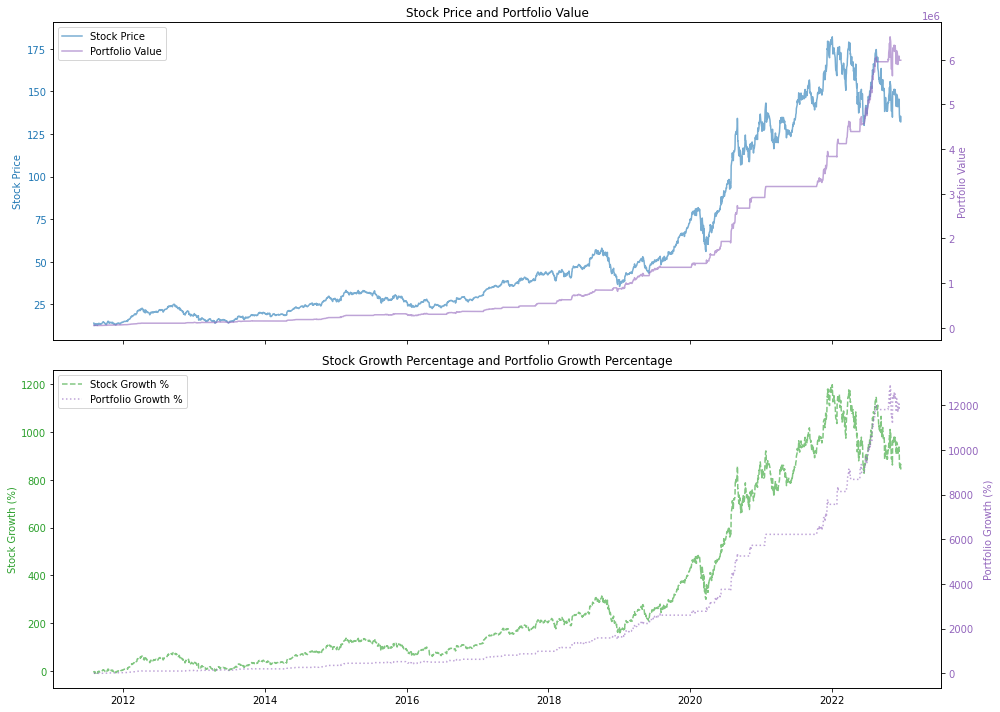

In [29]:
# Create a figure with 2 subplots (2 rows, 1 column)
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top Plot: Stock Price and Portfolio Value
ax1.set_ylabel('Stock Price', color='tab:blue')
ln1 = ax1.plot(date, stock_price, color='tab:blue', alpha=0.6, label="Stock Price")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Portfolio Value', color='tab:purple')
ln2 = ax2.plot(date, portfolio_value, color='tab:purple', alpha=0.6, label="Portfolio Value")
ax2.tick_params(axis='y', labelcolor='tab:purple')

lns1 = ln1 + ln2
labs1 = [l.get_label() for l in lns1]
ax1.legend(lns1, labs1, loc='upper left')
ax1.set_title("Stock Price and Portfolio Value")

# Bottom Plot: Stock Growth % and Portfolio Growth %
stock_growth_percentage = [(price - stock_price[0]) / stock_price[0] * 100 for price in stock_price]
ln3 = ax3.plot(date, stock_growth_percentage, color='tab:green', alpha=0.6, label="Stock Growth %", linestyle='dashed')
ax3.set_ylabel('Stock Growth (%)', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
portfolio_growth_percentage = [(value - starting_funds) / starting_funds * 100 for value in portfolio_value]
ln4 = ax4.plot(date, portfolio_growth_percentage, color='tab:purple', alpha=0.6, label="Portfolio Growth %", linestyle='dotted')
ax4.set_ylabel('Portfolio Growth (%)', color='tab:purple')
ax4.tick_params(axis='y', labelcolor='tab:purple')

lns2 = ln3 + ln4
labs2 = [l.get_label() for l in lns2]
ax3.legend(lns2, labs2, loc='upper left')
ax3.set_title("Stock Growth Percentage and Portfolio Growth Percentage")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


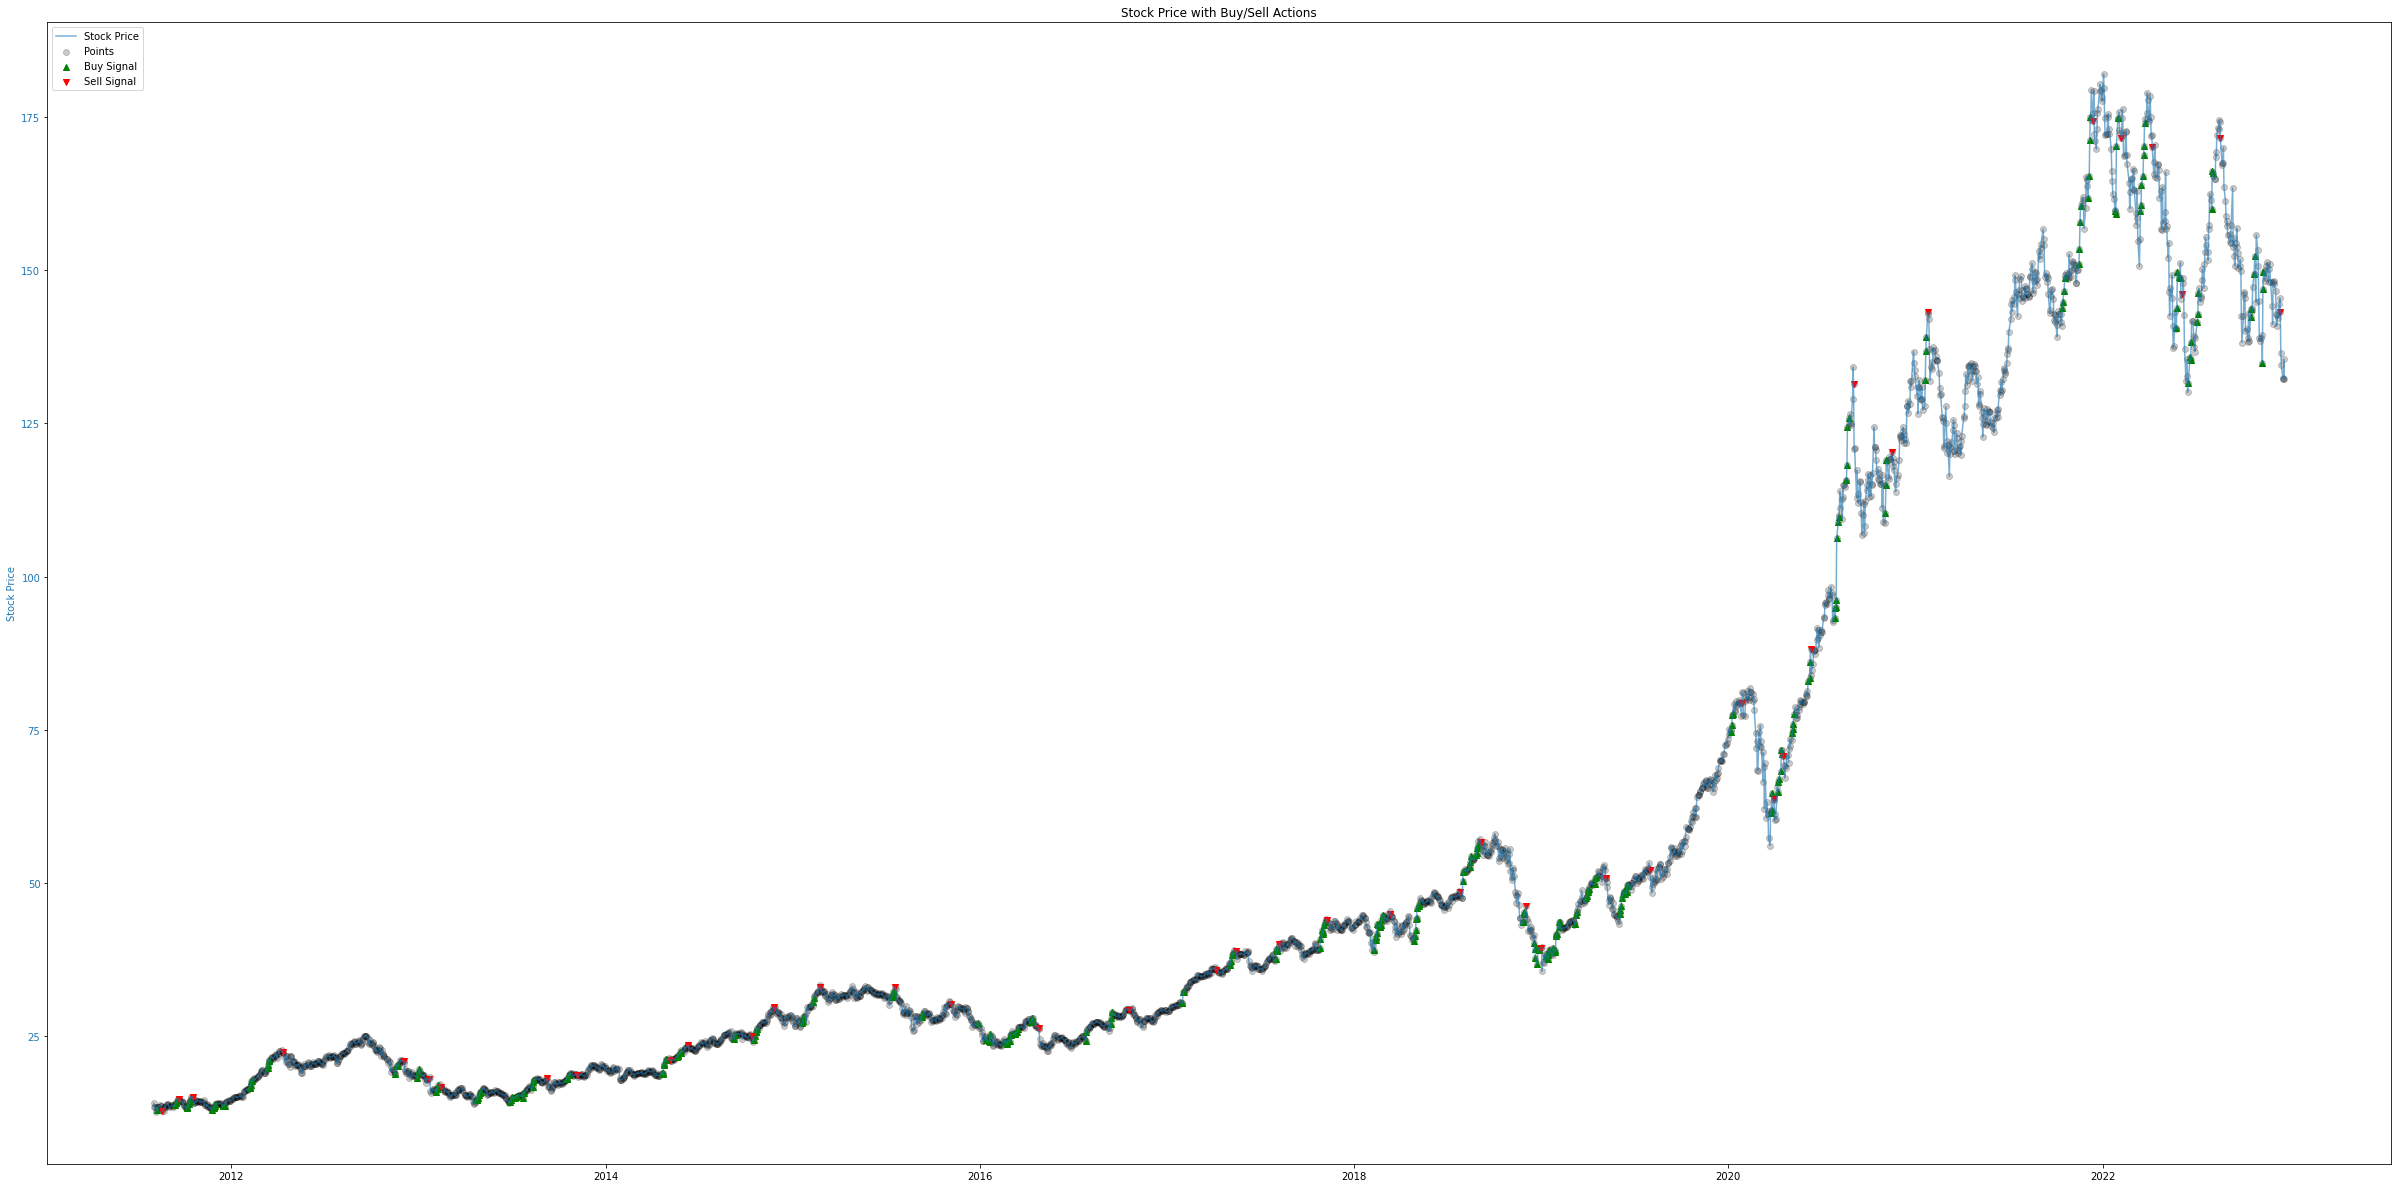

In [30]:
fig, ax1 = plt.subplots(figsize=(42, 21))

# Plotting Stock Price
ax1.set_ylabel('Stock Price', color='tab:blue')
ax1.plot(date, stock_price, color='tab:blue', alpha=0.6, label="Stock Price")
ax1.scatter(date, stock_price, color='black', marker='o', label="Points", alpha=0.2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Scatter plots for buy/sell signals
buy_idx = [date[i] for i in range(len(buys)) if buys[i] is not None]
sell_idx = [date[i] for i in range(len(sells)) if sells[i] is not None]
buy_prices = [buys[i] for i in range(len(buys)) if buys[i] is not None]
sell_prices = [sells[i] for i in range(len(sells)) if sells[i] is not None]

ax1.scatter(buy_idx, buy_prices, color='g', label="Buy Signal", marker='^', alpha=1)
ax1.scatter(sell_idx, sell_prices, color='r', label="Sell Signal", marker='v', alpha=1)

# Adding legend and showing the plot
ax1.legend(loc='upper left')
ax1.set_title("Stock Price with Buy/Sell Actions")
plt.show()

### LSTM, inspired by A deep learning framework for financial time series using stacked autoencoders and longshort term memory

## other

In [15]:
def determine_trend(df, short_window=50, long_window=200, threshold=0.01):
    """
    Determine the trend based on moving averages.
    
    Parameters:
    - df: DataFrame with the stock data
    - short_window: Window for the short-term SMA
    - long_window: Window for the long-term SMA
    - threshold: Percentage difference between SMAs to consider as 'No trend'
    
    Returns:
    - trend: List with 'Uptrend', 'Downtrend' or 'No trend' for each row in df
    """
    # Calculate short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # Calculate the trend
    conditions = [
        (df['Short_MA'] > df['Long_MA'] * (1 + threshold)), # Uptrend condition
        (df['Short_MA'] < df['Long_MA'] * (1 - threshold))  # Downtrend condition
    ]
    choices = ['Uptrend', 'Downtrend']
    
    df['Trend'] = np.select(conditions, choices, default='No trend')
    
    return df['Trend'].tolist()

In [16]:
stock_apple = stock_data['AAPL'].copy()
stock_apple['Trend'] = determine_trend(stock_apple)


In [17]:
def plot_stock_with_trend(df):
    apdict = [mpf.make_addplot(df['Short_MA'], color='blue', linestyle='--'),
              mpf.make_addplot(df['Long_MA'], color='red', linestyle='--')]
    
    mpf.plot(df, type='candle', style='yahoo', volume=True, title='Stock with Trend Indicator',
             ylabel='Price', figratio=(400, 120), mav=(100, 400), addplot=apdict, 
             hlines=dict(hlines=[df['Close'].mean()], colors=['blue'], linewidths=[2]))

plot_stock_with_trend(stock_apple)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Expect data.index as DatetimeIndex

In [ ]:
# Calculate the weekly return
stock_apple['Weekly_Return'] = stock_apple['Close'].resample('W').ffill().pct_change()


# Display statistics
stats = stock_apple['Weekly_Return'].describe()
stats

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Weekly_Return, dtype: float64